#  Аназиз данных молочного хозяйства "Вольный луг"

Владелец молочного хозяйства "Вольный луг" хочет расширить хозяйство. Чтобы тщательно отобрать коров, он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям.

Необходимо разработать модель машинного обучения, которая поможет управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нужно создать 2 прогнозные модели для отбора бурёнок в поголовье:

* Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);
* Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

*Цели проекта:*

Разработка моделей для прогназирования удоя молока и вкуса с целью отбора подходящих для покупки коров в "ЭкоФерме"

Загрузим необходимые библиотеки

In [1195]:
!pip install scikit-learn==1.1.3 -q

In [1196]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (r2_score, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             accuracy_score, 
                             precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [1197]:
pip install phik==0.9.7 -q

Note: you may need to restart the kernel to use updated packages.


In [1198]:
import phik

Напишем функцию вывода информации о df, чтобы не дублировать код

In [1199]:
def df_info(data):
    display(data.sample(7))
    display(data.info())
    print()
    print('Количество явных дубликатов: ', data.duplicated().sum())
    print()
    print('Количество пропусков:', data.isna().sum())

## Загрузка данных

**Описание ferma_main:**

* id — уникальный идентификатор коровы.
* Удой, кг — масса молока, которую корова даёт в год (в килограммах).
* ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
* Сырой протеин, г — содержание сырого протеина в корме (в граммах).
* СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Жирность,% — содержание жиров в молоке (в процентах).
* Белок,% — содержание белков в молоке (в процентах).
* Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [1200]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';', decimal=',')
df_info(ferma_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
340,341,5497,14.7,1751,0.84,Вис Бик Айдиал,Равнинное,Айдиал,3.18,3.074,не вкусно,менее_2_лет
611,612,5788,13.4,1914,0.89,Вис Бик Айдиал,Холмистое,Соверин,3.64,3.078,вкусно,более_2_лет
481,482,6742,14.7,1860,0.93,РефлешнСоверинг,Холмистое,Айдиал,3.70,3.072,не вкусно,более_2_лет
509,510,6232,16.1,2301,0.95,Вис Бик Айдиал,Равнинное,Соверин,3.74,3.079,вкусно,более_2_лет
143,144,5976,13.7,1795,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.58,3.076,не вкусно,более_2_лет
291,292,5816,14.7,1715,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.073,не вкусно,более_2_лет
257,258,5952,13.1,1795,0.89,РефлешнСоверинг,Равнинное,Соверин,3.63,3.074,не вкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None


Количество явных дубликатов:  5

Количество пропусков: id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64


**Описание ferma_dad:**

* id — уникальный идентификатор коровы.
* Имя Папы — имя папы коровы.

In [1201]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';', decimal=',')
df_info(ferma_dad)

,id,Имя Папы
562,563,Соловчик
143,144,Соловчик
101,102,Барин
54,55,Барин
544,545,Барин
2,3,Барин
514,515,Буйный


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None


Количество явных дубликатов:  0

Количество пропусков: id          0
Имя Папы    0
dtype: int64


**Описание cow_buy:**

* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Имя_папы — имя папы коровы.
* Текущая_жирность,% — содержание жиров в молоке (в процентах).
* Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [1202]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';', decimal=',')
df_info(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None


Количество явных дубликатов:  4

Количество пропусков: Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64


**Промежуточный вывод:**

* Во всех df стоит отредактировать названия столбцов (регистр букв, пробелы и прочерки);
* Жирность, белок, текущая жирность и текущий белок привести к типу float;
* В ferma_main убрать явные дубликаты, при этом дубликаты в cow_buy не удалять, так как мало данных;
* Пропуски не выявлены;
* Также сразу был задан разделитель для чисел, точка, вместо запятой - это поможет далее при форматировании столбцов.

##  Предобработка данных

Переименуем названия столбцов (избавитмся от пробелов, заменим из за "змеиный_регистр"; приведем все к строчным буквам; и сократим некоторые названия) и сразу проверим изменения

In [1203]:
ferma_main = ferma_main.rename(columns={
    'Удой, кг': 'удой',
    'ЭКЕ (Энергетическая кормовая единица)': 'эке',
    'Сырой протеин, г': 'протеин',
    'СПО (Сахаро-протеиновое соотношение)': 'спо',
    'Порода': 'порода_коровы',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_быка',
    'Жирность,%': 'жирность',
    'Белок,%': 'белок',
    'Вкус молока': 'вкус_молока',
    'Возраст': 'возраст'
})

print(ferma_main.columns)

Index(['id', 'удой', 'эке', 'протеин', 'спо', 'порода_коровы', 'тип_пастбища',
       'порода_быка', 'жирность', 'белок', 'вкус_молока', 'возраст'],
      dtype='object')


In [1204]:
ferma_dad = ferma_dad.rename(columns={
    'Имя Папы': 'имя_быка',
})

print(ferma_dad.columns)

Index(['id', 'имя_быка'], dtype='object')


In [1205]:
cow_buy = cow_buy.rename(columns={
    'Порода': 'порода_коровы',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_быка',
    'Имя_папы': 'имя_быка',
    'Текущая_жирность,%': 'жирность_текущая',
    'Текущий_уровень_белок,%': 'белок_текущий',
    'Возраст': 'возраст'
})

print(cow_buy.columns)

Index(['порода_коровы', 'тип_пастбища', 'порода_быка', 'имя_быка',
       'жирность_текущая', 'белок_текущий', 'возраст'],
      dtype='object')


Обработаем неявные дубликаты. Для этого подготовим функцию, которая будет выводить уникальные значения стобца 

In [1206]:
def dublicates(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            print(i, df[i].unique())

In [1207]:
dublicates(ferma_main)

порода_коровы ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип_пастбища ['Равнинное' 'Равнинные' 'Холмистое']
порода_быка ['Айдиал' 'Соверин' 'Айдиалл']
вкус_молока ['вкусно' 'не вкусно']
возраст ['более_2_лет' 'менее_2_лет']


Исправим два неявных дубликата: "Равнинное" и "Равнинные", "Айдиал" и "Айдиалл" и проверим результат.

In [1208]:
ferma_main['тип_пастбища'].replace({'Равнинные': 'Равнинное'}, inplace=True)
ferma_main['порода_быка'].replace({'Айдиалл': 'Айдиал'}, inplace=True)

display(ferma_main['тип_пастбища'].unique())
display(ferma_main['порода_быка'].unique())

array(['Равнинное', 'Холмистое'], dtype=object)

array(['Айдиал', 'Соверин'], dtype=object)

In [1209]:
dublicates(ferma_dad)

имя_быка ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


In [1210]:
dublicates(cow_buy)

порода_коровы ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип_пастбища ['холмистое' 'равнинное']
порода_быка ['Айдиал' 'Соверин']
имя_быка ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
возраст ['более_2_лет' 'менее_2_лет']


В датасете ferma_dad не наблюдается неявных дубликатов.

В cow_buy приведем значения колонок порода_быка и возраст к первой заглавной букве.

In [1211]:
cow_buy['тип_пастбища'].replace({'холмистое': 'Холмистое', 'равнинное': 'Равнинное'}, inplace=True)

display(ferma_main['тип_пастбища'].unique())

array(['Равнинное', 'Холмистое'], dtype=object)

Удалим явные дубликаты в ferma_main (5 шт.):

In [1212]:
ferma_main.drop_duplicates(inplace=True)

print('Количество явных дубликатов в ferma_main:', ferma_main.duplicated().sum())

Количество явных дубликатов в ferma_main: 0


**Промежуточный вывод:**

* Названия всех столбцов, всех датафреймов были приведены к "змеиному_регистру";
* Были исправлены явные дубликаты и удалены неявные дубликаты.

## Исследовательский анализ данных

Начнем анализ данных со статистического анализа всех признаков в датафрейме ferma_main.

In [1213]:
display(ferma_main.head())
ferma_main.describe().T

,id,удой,эке,протеин,спо,порода_коровы,тип_пастбища,порода_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
удой,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
эке,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
протеин,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
спо,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
жирность,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
белок,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


**Промежуточный вывод:** 

При анализе значений среднего, медианы, максимума и минимума наблюдается аномальное значение максимального удоя (45616 кг). Остальные данные не вызывают вопросов и распределены достаточно логично.

Далее рассмотрим количественные признаки более наглядно - это поможет найти закономерности или увидеть другие аномалии.

### Количественные признаки

**Признак "удой"**

In [1214]:
ferma_main['удой'].sort_values(ascending=False).head(3)

16     45616
70      7222
135     7207
Name: удой, dtype: int64

[Text(0.5, 1.0, 'Распределение признака "удой":')]

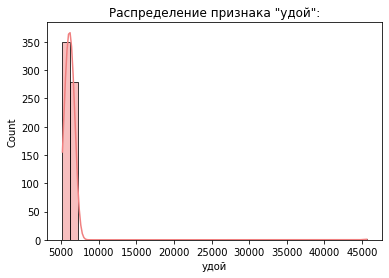

In [1215]:
sns.histplot(data = ferma_main,x = 'удой', 
             bins = 40, kde=True, color='lightcoral', 
             edgecolor='black').set(title = 'Распределение признака "удой":')

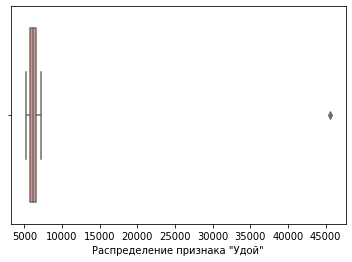

In [1216]:
sns.boxplot(x=ferma_main['удой'], color='lightcoral')
plt.xlabel('Распределение признака "Удой"')
plt.show()

In [1217]:
ferma_main = ferma_main.query('удой != 45616')

ferma_main['удой'].sort_values(ascending=False).head(3)

70     7222
135    7207
296    7201
Name: удой, dtype: int64

Построим графики после удаления выброса:

[Text(0.5, 1.0, 'Распределение признака "удой":')]

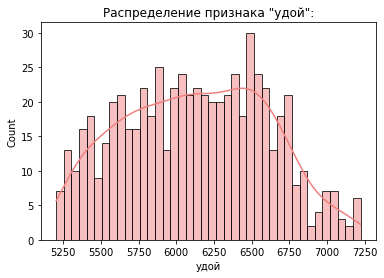

In [1218]:
sns.histplot(data = ferma_main,x = 'удой', 
             bins = 40, kde=True, 
             color='lightcoral', 
             edgecolor='black'
            ).set(title = 'Распределение признака "удой":')

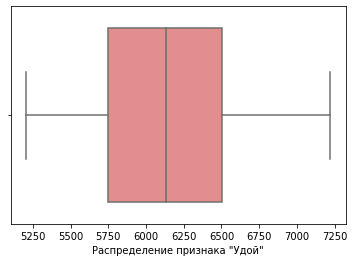

In [1219]:
sns.boxplot(x=ferma_main['удой'], color='lightcoral')
plt.xlabel('Распределение признака "Удой"')
plt.show()

**Промежуточный вывод:**

С помощью сортировки по возразнанию и ящика с усами, мы определеили, что признак "удой" имеет единственный выброс, который был удален.

**Признак "эке"**

[Text(0.5, 1.0, 'Распределение признака "эке":')]

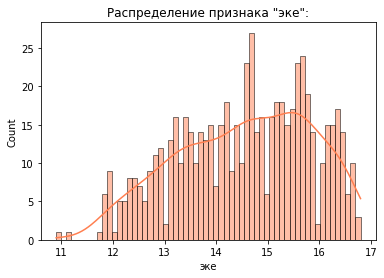

In [1220]:
sns.histplot(data = ferma_main,x = 'эке', 
             bins = 60, kde=True, 
             color='coral', 
             edgecolor='black'
            ).set(title = 'Распределение признака "эке":')

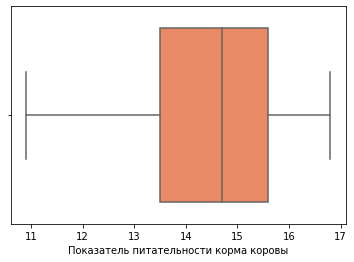

In [1221]:
sns.boxplot(x=ferma_main['эке'], color='coral')
plt.xlabel('Показатель питательности корма коровы')
plt.show()

**Промежуточный вывод:**

Распределение показателя питательности корма коровы близко к нормальному. Выбросов нет.

**Признак "протеин"**

[Text(0.5, 1.0, 'Содержание сырого протеина в корме, г')]

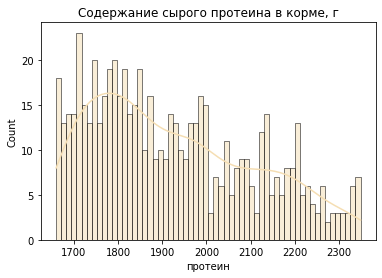

In [1222]:
sns.histplot(data = ferma_main,x = 'протеин', 
             bins = 60, kde=True, 
             color='wheat', 
             edgecolor='black'
            ).set(title = 'Содержание сырого протеина в корме, г')

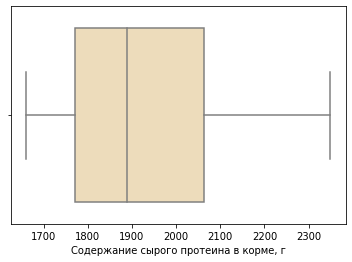

In [1223]:
sns.boxplot(x=ferma_main['протеин'], color='wheat')
plt.xlabel('Содержание сырого протеина в корме, г')
plt.show()

**Промежуточный вывод:**

Распределение показателя содержания сырого протеина в корме выглядит достоверно: оно значения расположены по убыванию, выбросов нет.

**Признак "спо"**

[Text(0.5, 1.0, 'Отношение сахара к протеину в корме')]

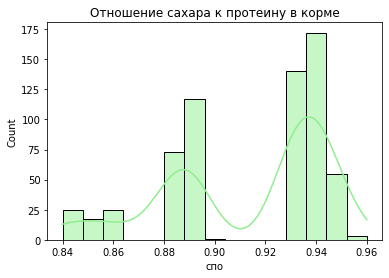

In [1224]:
sns.histplot(data = ferma_main,x = 'спо', 
             bins = 15, kde=True, 
             color='lightgreen', 
             edgecolor='black'
            ).set(title = 'Отношение сахара к протеину в корме')

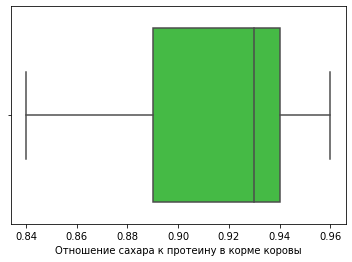

In [1225]:
sns.boxplot(x=ferma_main['спо'], color='limegreen')
plt.xlabel('Отношение сахара к протеину в корме коровы')
plt.show()

**Промежуточный вывод:**

Распределение отношения сахара к протеину в корме выбросов не имеет, приэтом распреление выглядит, будто сгрупперовано по значениям.

**Признак "жирность"**

[Text(0.5, 1.0, 'Cодержание жиров в молоке, %')]

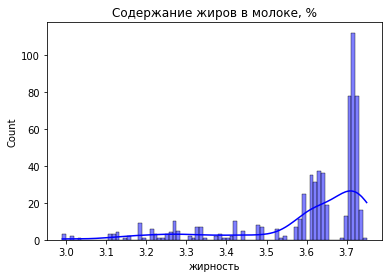

In [1226]:
sns.histplot(data = ferma_main,x = 'жирность', 
             bins = 80, kde=True, 
             color='blue', 
             edgecolor='black'
            ).set(title = 'Cодержание жиров в молоке, %')

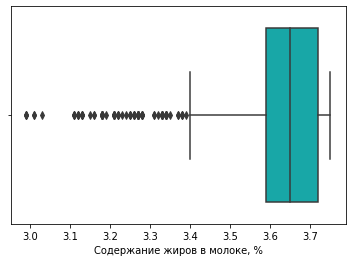

In [1227]:
sns.boxplot(x=ferma_main['жирность'], color='c')
plt.xlabel('Cодержание жиров в молоке, %')
plt.show()

Проанализируем выбросы в данном признаке.

Возьмем все количество значений до 3.4 (то есть выбросы слева) и разделим на общее количество значений в датасете. Тем самым мы получим процент выбросов - это поможет сделать вывод, на сколько их много и стоит ли удалять данные выбросы.

In [1228]:
procent_vibrosov_jirnost = (len(ferma_main.query("жирность < 3.4")) / len(ferma_main)) * 100
print(f'процент выбросов в признаке "жирность" равна {round(procent_vibrosov_jirnost, 2)}%')

процент выбросов в признаке "жирность" равна 13.69%


**Промежуточный вывод:**

По "ящику с усами" наблюдается большое количество выбросов, их процентное соотношение составляет 13.69%, при этом разброс данных варьируется 2.99 до 3.75 - можно сделать вывод, что не стоит удалять выбросы.

**Признак "белок"**

[Text(0.5, 1.0, 'Cодержание белка в молоке, %')]

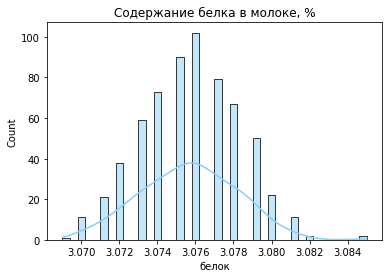

In [1229]:
sns.histplot(data = ferma_main,x = 'белок', 
             bins = 40, kde=True, 
             color='lightskyblue', 
             edgecolor='black'
            ).set(title = 'Cодержание белка в молоке, %')

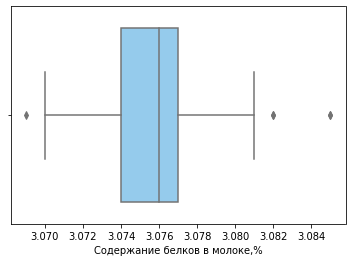

In [1230]:
sns.boxplot(x=ferma_main['белок'], color='lightskyblue')
plt.xlabel('Cодержание белков в молоке,%')
plt.show()

У признака "белок" также имеются выбросы, но их количество и расположение отличается от значений признака "жирность". Рассмотрим аналогично процентное количество выбросов в датасете признака "белок", задав границы значений до 3.069 и более 3.081.

In [1231]:
procent_vibrosov_belok = (len(ferma_main) - len(ferma_main.query('3.069 < белок < 3.081'))) / len(ferma_main) * 100
print(f'Процент выбросов в признаке "белок" равна {round(procent_vibrosov_belok, 2)}%')

Процент выбросов в признаке "белок" равна 2.55%


Учитывая, что выбросов менее 3%, а это незначительное количество записей в датафрейме, удалим их.

In [1232]:
ferma_main = ferma_main.query('3.069 < белок < 3.081')

### Категориальные признаки

Для анализа категориальных признаков будем использовать диаграмму pie - она наглядно покажет процентное соотношение признаков в столбце.

**Признак "порода"**

Вис Бик Айдиал     358
РефлешнСоверинг    254
Name: порода_коровы, dtype: int64

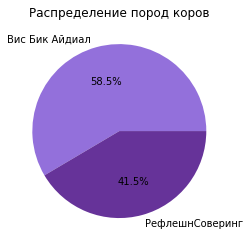

In [1233]:
display(ferma_main['порода_коровы'].value_counts())

plt.pie(
    ferma_main['порода_коровы'].value_counts(),
    labels=['Вис Бик Айдиал ', 'РефлешнСоверинг'],
    autopct='%1.1f%%',
    colors=['mediumpurple', 'rebeccapurple']
)
plt.title('Распределение пород коров')
plt.grid()
plt.show()

**Промежуточный вывод:**

Соотношение друх пород практически в равных долях, выглядит нормальным.

**Признак "тип_пастбища"**

Холмистое    341
Равнинное    271
Name: тип_пастбища, dtype: int64

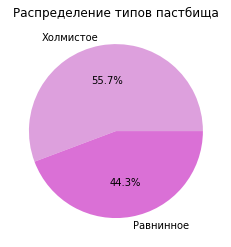

In [1234]:
display(ferma_main['тип_пастбища'].value_counts())

plt.pie(
    ferma_main['тип_пастбища'].value_counts(),
    labels=['Холмистое', 'Равнинное'],
    autopct='%1.1f%%',
    colors=['plum', 'orchid']
)
plt.title('Распределение типов пастбища')
plt.show()

**Промежуточный вывод:**

Соотношение типов пастбищ, холмистое и равнинное, также практически равно и выглядит нормальным.

**Признак "порода_быка"**

Айдиал     310
Соверин    302
Name: порода_быка, dtype: int64

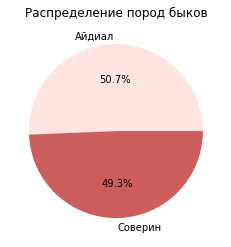

In [1235]:
display(ferma_main['порода_быка'].value_counts())

plt.pie(
    ferma_main['порода_быка'].value_counts(),
    labels=['Айдиал', 'Соверин'],
    autopct='%1.1f%%',
    colors=['mistyrose', 'indianred']
)
plt.title('Распределение пород быков')
plt.grid()
plt.show()

**Промежуточный вывод:**

Аналогичная картина соотношения пород быков, выглядящее нормальным.

**Признак "вкус_молока"**

вкусно       357
не вкусно    255
Name: вкус_молока, dtype: int64

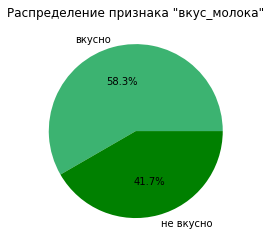

In [1236]:
display(ferma_main['вкус_молока'].value_counts())

plt.pie(
    ferma_main['вкус_молока'].value_counts(),
    labels=['вкусно', 'не вкусно'],
    autopct='%1.1f%%',
    colors=['mediumseagreen', 'g']
)
plt.title('Распределение признака "вкус_молока"')
plt.grid()
plt.show()

**Промежуточный вывод:**

В данном распределении вкусного молока больше - что не может не радовать и выглядеть реалистичным.

**Признак "возраст"**

более_2_лет    506
менее_2_лет    106
Name: возраст, dtype: int64

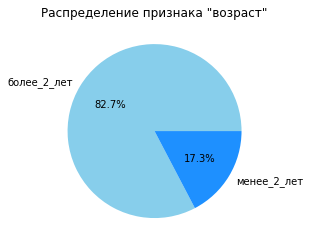

In [1237]:
display(ferma_main['возраст'].value_counts())

plt.pie(
    ferma_main['возраст'].value_counts(),
    labels=['более_2_лет', 'менее_2_лет'],
    autopct='%1.1f%%',
    colors=['skyblue', 'dodgerblue']
)
plt.title('Распределение признака "возраст"')
plt.grid()
plt.show()

**Промежуточный вывод:**

Возраст более 2 лет значительно преобладает у коров.

**Промежуточный вывод:**

После построения гистограмм и графиков распределения было замечено следующее:
* ЭКЕ и белок имеют нормальное распределение
* График удоя преобрел нормальное распределение после удаления одного выброса;
* Распределение показателя содержания сырого протеина в корме распределено не нормально, но выглядит достоверно;
* Распределение жиров имеет много выбросов (13%), но значения не сильно варьируются, поэтому с данными выбросами никакие действия не были совершены;
* Показатель СПО нельзя отнести к какому-то типу, но при этом ранный показатель будто сгруппирован.

Из диаграмм категориальных признаков можно сделать следующие выводы:
* Порода коров Вис Бик Айдиал слегка преобладает над породой РефлешнСоверинг (на 10%), а породы быков распределены в равных долях;
* Соотношение типов пастбищ равно;
* Вкусного молока больше чем не вкусного;
* Основная доля коров старше 2 лет (82,7%).

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между всеми признаками, чтобы изучить взаимосвязь между ними

/opt/conda/lib/python3.9/site-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 0.863999999999992 - 0.875999999999993
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/opt/conda/lib/python3.9/site-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 0.9119999999999959 - 0.9239999999999969
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))


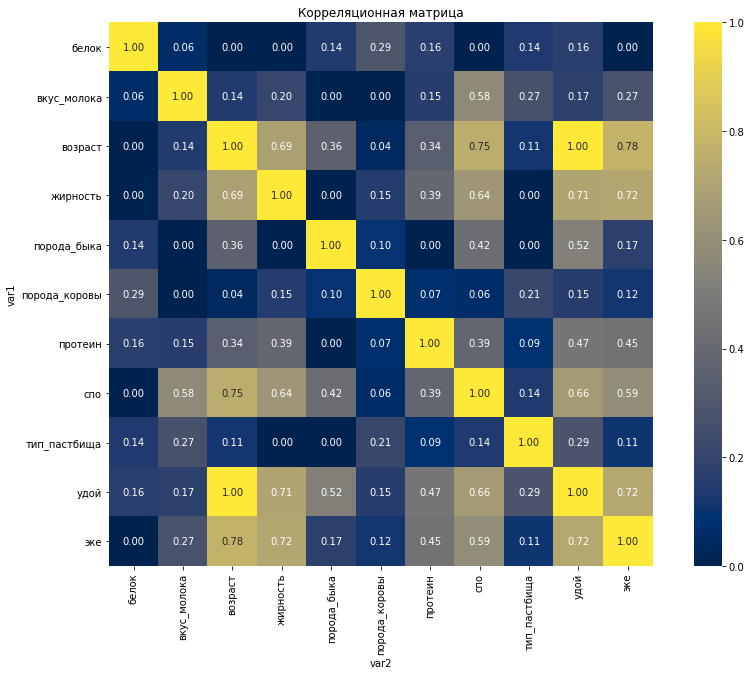

In [1238]:
plt.figure(figsize=(15, 10))
sns.heatmap(ferma_main.drop('id', axis=1).phik_matrix(interval_cols=['удой', 'жирность', 'протеин', 'спо', 'эке']), 
            vmax=1, square=True, annot=True, fmt=".2f", cmap='cividis')
plt.title("Корреляционная матрица")
plt.show()

**Промежуточный вывод:**

В корреляционной сатрице наблюдлаем следующие взаимосвязи:
* Удой напрямую зависит от возраста - про увеличении возраста удой растет;
* Видна зависимость меду возрастом и эке, возрастом и спо, но не такая "сильная";
* Совершенно нет корреляционной связи между следующими парами: белок-эке, белок-спо, белок-жирность, возраст-белок, вкус молока-порода, жирность-порода, жирность-тип пастбища, протеин-порода;
* Остальные пары имеют незначительную корреляцию.

**Построение диаграмм рассеяния для признака "удой" и всех количественных признаков с учетом значения категориальных признаков**

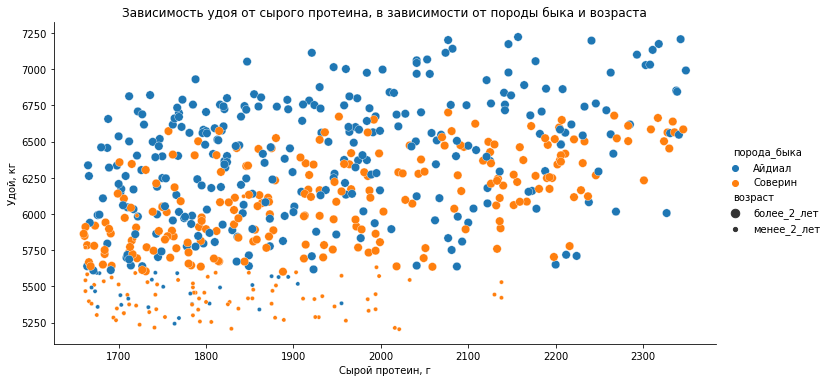

In [1239]:
sns.relplot(data = ferma_main, x = 'протеин', y ='удой', hue = 'порода_быка', size = 'возраст', aspect = 2)
plt.title('Зависимость удоя от сырого протеина, в зависимости от породы быка и возраста')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Корреляция междуу удоем и протеином = 0.47 - она положительная, но зависимость несильная, при этом на диаграмме рассеяния видно, что у породы Айдиал больше содержание протеина в молоке чем у породы Соверин.

Также удой коров старше двух лет больше.

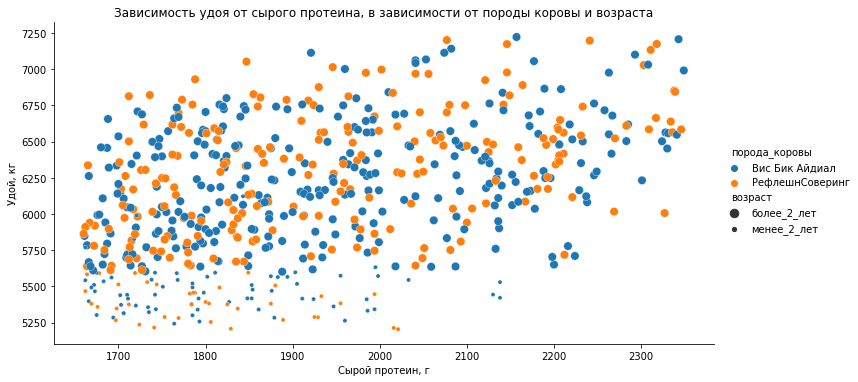

In [1240]:
sns.relplot(data = ferma_main, x = 'протеин', y ='удой', hue = 'порода_коровы', size = 'возраст', aspect = 2)
plt.title('Зависимость удоя от сырого протеина, в зависимости от породы коровы и возраста')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Картина зависимостей удоя и протеина в зависимости от породы коровы аналогична, как и у быков.

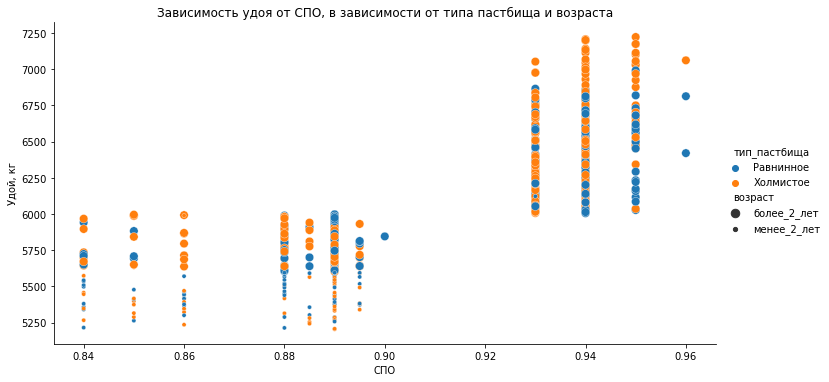

In [1241]:
sns.relplot(data = ferma_main, x = 'спо', y ='удой', hue = 'тип_пастбища', size = 'возраст', aspect = 2)
plt.title('Зависимость удоя от СПО, в зависимости от типа пастбища и возраста')
plt.xlabel('СПО')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Зависимость удоя от СПО максимальнана при холмитом пастбище у короб старше 2 лет

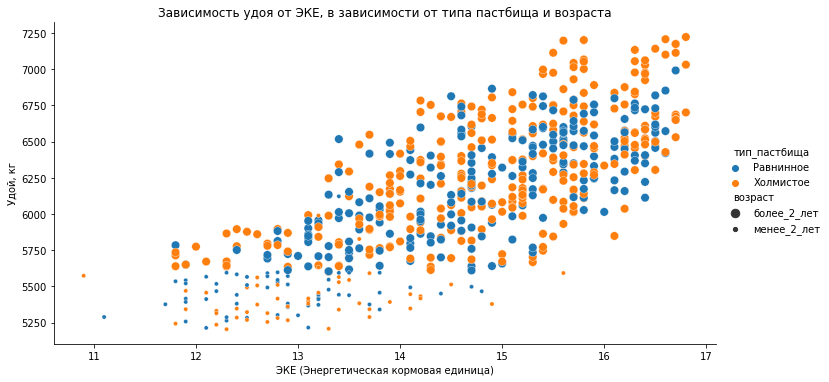

In [1242]:
sns.relplot(data = ferma_main, x = 'эке', y ='удой', hue = 'тип_пастбища', size = 'возраст', aspect = 2)
plt.title('Зависимость удоя от ЭКЕ, в зависимости от типа пастбища и возраста')
plt.xlabel('ЭКЕ (Энергетическая кормовая единица)')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Корреляция удоя и ЭКЕ = 0.72 - сильная и положительная корреляция. Можно сделать вывод о зависимости данным переменных. Также на диаграмме видно, что у вдрослых коров удой больше.

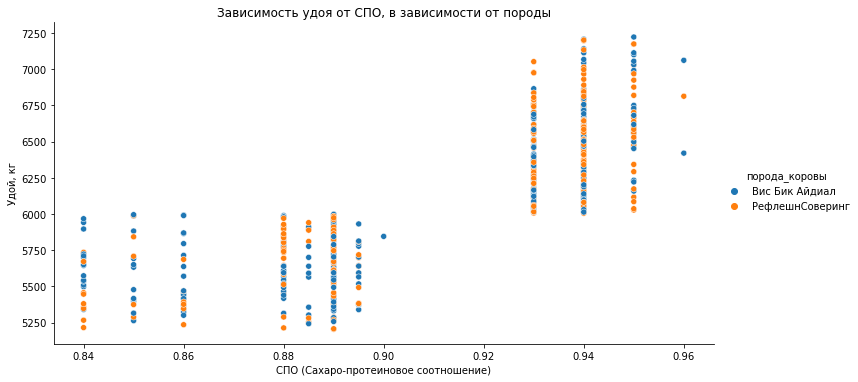

In [1243]:
sns.relplot(data = ferma_main, x = 'спо', y ='удой', hue = 'порода_коровы', aspect = 2)
plt.title('Зависимость удоя от СПО, в зависимости от породы')
plt.xlabel('СПО (Сахаро-протеиновое соотношение)')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Корреляция = 0.66, что показывает сильную положительную зависимость между удоем и СПО. При этом распределение на диграмме рассеяния нетипичное. 

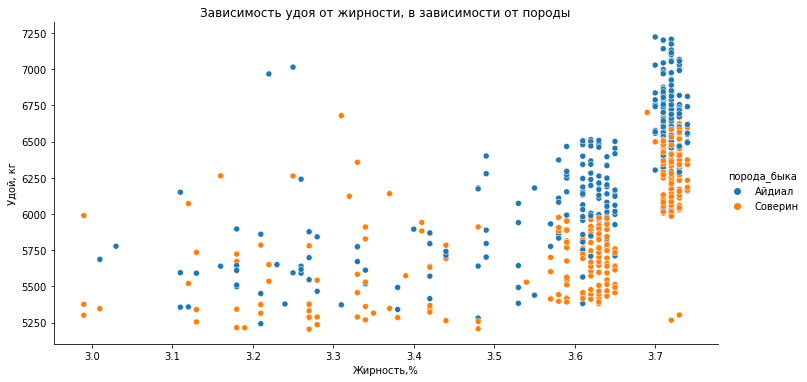

In [1244]:
sns.relplot(data = ferma_main, x = 'жирность', y ='удой', hue = 'порода_быка', aspect = 2)
plt.title('Зависимость удоя от жирности, в зависимости от породы')
plt.xlabel('Жирность,%')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Корреляция = 0.71 - положительгная зависимость удоя и жирности, однако зависимость нелинейная.

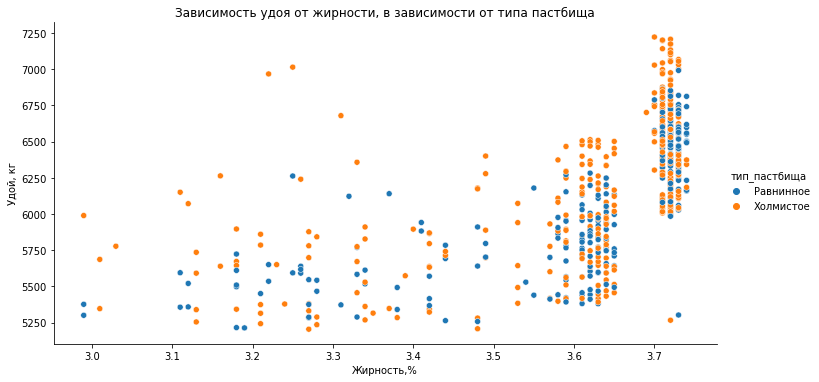

In [1245]:
sns.relplot(data = ferma_main, x = 'жирность', y ='удой', hue = 'тип_пастбища', aspect = 2)
plt.title('Зависимость удоя от жирности, в зависимости от типа пастбища')
plt.xlabel('Жирность,%')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Корреляция удоя и жирности равна 0.71, но зависимость нелинейна.

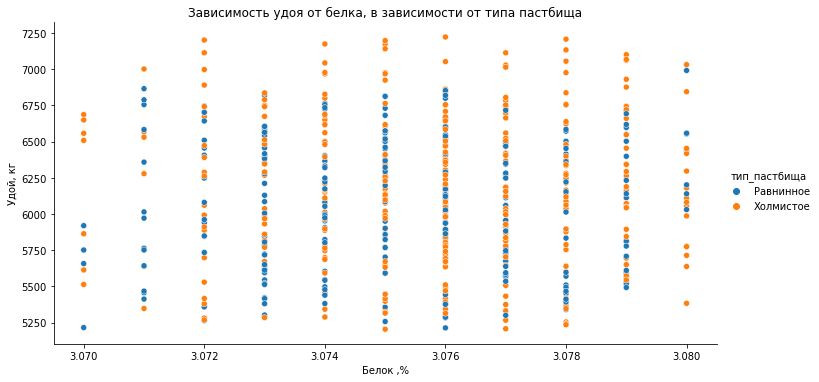

In [1246]:
sns.relplot(data = ferma_main, x = 'белок', y ='удой', hue = 'тип_пастбища', aspect = 2)
plt.title('Зависимость удоя от белка, в зависимости от типа пастбища')
plt.xlabel('Белок ,%')
plt.ylabel('Удой, кг')
plt.show()

**Промежуточный вывод:**

Корреляция удоя и белкаравна 0.19 - зависимость между параметрами незначительна.

## Обучение модели линейной регрессии

Подготовим данные датасета для обучения модели LinearRegression.

В качестве целевого признача используев удой. Для входных признаков используем остальные, кроме id, белка, жирности и вкуса молока, так как эти параметры относятся к уже полученному молоку и не влияют на удой.

In [1247]:
y = ferma_main['удой']
X = ferma_main.drop(['удой', 'id', 'белок', 'жирность', 'вкус_молока'], axis = 1)
RANDOM_STATE = 42

# разобъем данные на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    ) 

# подготовим списки категориальные и количественных признаков
cat_col_names = ['порода_коровы', 'тип_пастбища', 'порода_быка', 'возраст']
num_col_names = ['эке', 'протеин', 'спо']

In [1248]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1249]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [1250]:
predictions = model_lr.predict(X_test)
r2 = r2_score(y_test, predictions) 
print(r2)

0.7953683335703938


**Промежуточный вывод:**

Коэффициент детерминации равен 0.79 - это говорит о том, что модель работает достаточно точно (чем ближе к 1, тем точнее модель), но какие-то ошибки все равно имеются. Поэтому стоит рассмотреть остатки и их распределение

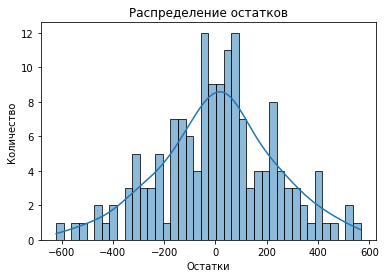

In [1251]:
sns.histplot(data = y_test-predictions, bins = 40, kde=True)
plt.xlabel('Остатки')
plt.ylabel('Количество')
plt.title('Распределение остатков')  
plt.show()

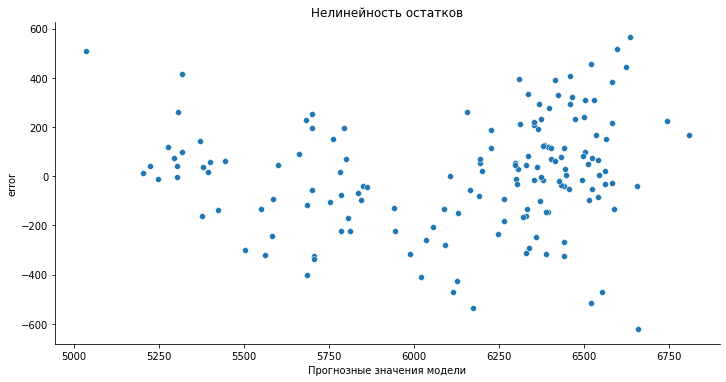

In [1252]:
sns.relplot(x = predictions, y =y_test-predictions, aspect = 2)
plt.xlabel('Прогнозные значения модели')
plt.ylabel('error')
plt.title('Нелинейность остатков')
plt.show()

**Промежуточный вывод:**

График остатков симметричен относительно 0. Получается, что разница между истиными значениями и предсказанными принимает как положительные, так и отрицательные значения - таки значения уравновешивают друг друга. Такая модель работает качественно. Распределение нормальное, выбросов не наблюдается.

У дисперсии остатков наблюдается непостоянство остатков, виднеется "рупор" - из-за этього модель может стать ненадежной и непредсказуемой.

In [1253]:
# Метрика MSE
mean_squared_error(y_test, predictions) 

50703.42332113209

In [1254]:
# Метрика RMSE
mean_squared_error(y_test, predictions, squared = False) 

225.1742066070892

In [1255]:
# Метрика MAE
mean_absolute_error(y_test, predictions) 

174.40827799480968

In [1256]:
#Переведём СПО в категориальный бинарный признак

ferma_main['спо_кат'] = ferma_main['спо'].apply(lambda x: 1.0 if x > 0.92 else 0.0)

ferma_main['эке2'] = ferma_main['эке'] ** 2

ferma_main.sample(7)

,id,удой,эке,протеин,спо,порода_коровы,тип_пастбища,порода_быка,жирность,белок,вкус_молока,возраст,спо_кат,эке2
45,46,5796,14.1,1797,0.895,Вис Бик Айдиал,Равнинное,Айдиал,3.49,3.074,вкусно,более_2_лет,0.0,198.81
162,163,5992,13.1,1676,0.860,Вис Бик Айдиал,Холмистое,Айдиал,3.59,3.072,вкусно,более_2_лет,0.0,171.61
412,413,5510,12.8,1672,0.880,Вис Бик Айдиал,Холмистое,Соверин,3.59,3.076,не вкусно,менее_2_лет,0.0,163.84
250,251,6471,15.3,2100,0.930,РефлешнСоверинг,Равнинное,Айдиал,3.73,3.077,не вкусно,более_2_лет,1.0,234.09
422,423,6681,14.6,2171,0.950,Вис Бик Айдиал,Равнинное,Айдиал,3.73,3.075,вкусно,более_2_лет,1.0,213.16
568,569,5989,13.2,1721,0.860,Вис Бик Айдиал,Холмистое,Соверин,2.99,3.076,вкусно,менее_2_лет,0.0,174.24
226,227,7100,16.6,2293,0.950,Вис Бик Айдиал,Холмистое,Айдиал,3.72,3.079,вкусно,более_2_лет,1.0,275.56


In [1257]:
y = ferma_main['удой']
X = ferma_main.drop(['удой', 'id', 'жирность', 'белок', 'вкус_молока', 'эке', 'спо'], axis = 1)

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

cat_col_names = ['порода_коровы', 'тип_пастбища', 'порода_быка', 'возраст', 'спо_кат']
num_col_names = ['протеин', 'эке2']

In [1258]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1259]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [1260]:
predictions = model_lr.predict(X_test)
r2 = r2_score(y_test, predictions) 
r2

0.8316394873761661

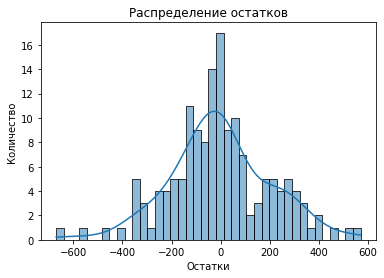

In [1261]:
sns.histplot(data = y_test-predictions, bins = 40, kde=True)
plt.xlabel('Остатки')
plt.ylabel('Количество')
plt.title('Распределение остатков')  
plt.show()

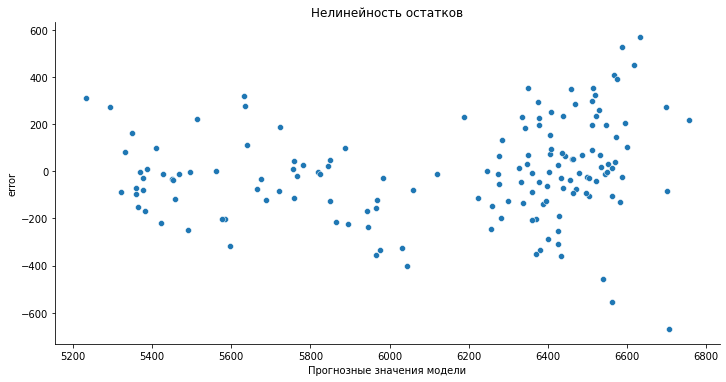

In [1262]:
sns.relplot(x = predictions, y =y_test-predictions, aspect = 2)
plt.xlabel('Прогнозные значения модели')
plt.ylabel('error')
plt.title('Нелинейность остатков')
plt.show()

In [1263]:
# Метрика MSE
mean_squared_error(y_test, predictions) 

41716.19422874426

In [1264]:
# Метрика RMSE
mean_squared_error(y_test, predictions, squared = False) 

204.24542645734874

In [1265]:
# Метрика MAE
mean_absolute_error(y_test, predictions)

153.9553602588597

**Промедуточный вывод:**

Значение метрики увеличилось с 0.795 до 0.832. Распределение остатков также стало ближе к нормальному. Больших изменений в дисперсии не наблюдается. Метрики уменьшились, что говорит об улучшении предсказывания целевого признака.


Для третьей модели добавляем признак "Имя быка"

In [1266]:
#Добавим столбец с именем отца

ferma_main = ferma_main.merge(ferma_dad, on = 'id')
display(ferma_main.head(5))

,id,удой,эке,протеин,спо,порода_коровы,тип_пастбища,порода_быка,жирность,белок,вкус_молока,возраст,спо_кат,эке2,имя_быка
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84,Барин


In [1267]:
y = ferma_main['удой']
X = ferma_main.drop(['удой', 'id', 'жирность', 'белок', 'вкус_молока', 'эке', 'спо'], axis = 1)
RANDOM_STATE = 42

# разобъем данные на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    ) 

# подготовим списки категориальные и количественных признаков
cat_col_names = ['порода_коровы', 'тип_пастбища', 'порода_быка', 'возраст', 'спо_кат', 'имя_быка']
num_col_names = ['протеин', 'эке2']

In [1268]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1269]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [1270]:
predictions = model_lr.predict(X_test)
r2 = r2_score(y_test, predictions) 
r2

0.845708149194399

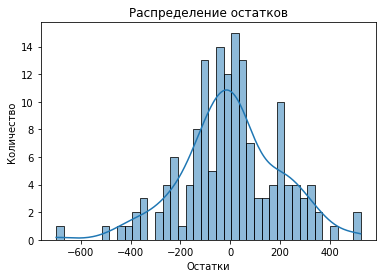

In [1271]:
sns.histplot(data = y_test-predictions, bins = 40, kde=True)
plt.xlabel('Остатки')
plt.ylabel('Количество')
plt.title('Распределение остатков')  
plt.show()

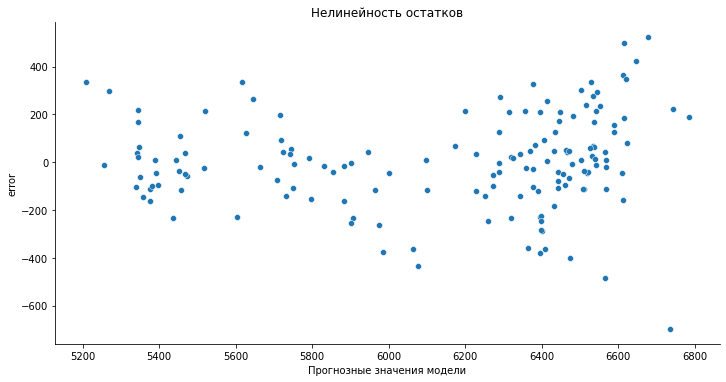

In [1272]:
sns.relplot(x = predictions, y =y_test-predictions, aspect = 2)
plt.xlabel('Прогнозные значения модели')
plt.ylabel('error')
plt.title('Нелинейность остатков')
plt.show()

In [1273]:
# Метрика MSE
mean_squared_error(y_test, predictions) 

38230.27570900674

In [1274]:
# Метрика RMSE
mean_squared_error(y_test, predictions, squared = False) 

195.52563951821443

In [1275]:
# Метрика MAE
mean_absolute_error(y_test, predictions)

147.07797995157966

**Промедуточный вывод:**

Значение коэффициента детерминации вырос с 0.795 до 0.8456. Распределение остатков улучшилось, но смещение осталось. Дисперсия стала значительно плотнее и равномерней. 

Добавление признака в виде имени быка повлияло на модель положительно. Также с точки зрения оценки по метрикам MSE, MAE и RMSE третья модель имеет наилучшие показатели. Чем меньше ошибки, тем лучше модель предсказывает целевой признак.

Спрогназируем удой коров.

In [1276]:
ferma_main.sample(7)

,id,удой,эке,протеин,спо,порода_коровы,тип_пастбища,порода_быка,жирность,белок,вкус_молока,возраст,спо_кат,эке2,имя_быка
591,609,6405,15.6,1787,0.93,Вис Бик Айдиал,Холмистое,Соверин,3.73,3.077,не вкусно,более_2_лет,1.0,243.36,Соловчик
564,582,5573,10.9,1955,0.84,Вис Бик Айдиал,Холмистое,Соверин,3.39,3.079,вкусно,менее_2_лет,0.0,118.81,Барин
148,154,6288,15.6,1981,0.94,Вис Бик Айдиал,Равнинное,Соверин,3.71,3.076,вкусно,более_2_лет,1.0,243.36,Барин
482,499,5988,13.3,1784,0.85,РефлешнСоверинг,Холмистое,Айдиал,3.62,3.075,не вкусно,более_2_лет,0.0,176.89,Буйный
442,456,6322,15.2,1971,0.94,Вис Бик Айдиал,Равнинное,Айдиал,3.71,3.075,вкусно,более_2_лет,1.0,231.04,Геркулес
342,354,6455,14.8,1835,0.93,РефлешнСоверинг,Равнинное,Соверин,3.71,3.072,не вкусно,более_2_лет,1.0,219.04,Соловчик
212,220,6110,15.2,2136,0.94,Вис Бик Айдиал,Холмистое,Соверин,3.71,3.074,вкусно,более_2_лет,1.0,231.04,Барин


In [1277]:
# Добавляем необходимые столбцы в датафрейм cow_buy

cow_buy['эке'] = ferma_main['эке'].mean()*1.05
cow_buy['протеин'] = ferma_main['протеин'].mean()*1.05
cow_buy['спо'] = ferma_main['спо'].mean()*1.05

cow_buy.sample(7)

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность_текущая,белок_текущий,возраст,эке,протеин,спо
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.271152,2018.417402,0.95888
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271152,2018.417402,0.95888
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,15.271152,2018.417402,0.95888
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.271152,2018.417402,0.95888
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.271152,2018.417402,0.95888
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271152,2018.417402,0.95888


In [1278]:
cow_buy['спо_кат'] = cow_buy['спо'].apply(lambda x: 1.0 if x > 0.92 else 0.0)

cow_buy['эке2'] = cow_buy['эке'] ** 2

cow_buy.sample(7)

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность_текущая,белок_текущий,возраст,эке,протеин,спо,спо_кат,эке2
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082


In [1279]:
ferma_main.head()

,id,удой,эке,протеин,спо,порода_коровы,тип_пастбища,порода_быка,жирность,белок,вкус_молока,возраст,спо_кат,эке2,имя_быка
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84,Барин


In [1280]:
X = cow_buy.drop(['белок_текущий', 'жирность_текущая', 'эке', 'спо'], axis = 1)

X = X[['порода_коровы', 'тип_пастбища', 'порода_быка', 'возраст','имя_быка', 'протеин', 'спо_кат', 'эке2']]

cat_col_names = ['порода_коровы', 'тип_пастбища', 'порода_быка', 'возраст', 'спо_кат', 'имя_быка']
num_col_names = ['протеин', 'эке2']

In [1281]:
X_ohe = encoder.transform(X[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_scaled = scaler.transform(X[num_col_names])
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)
X = pd.concat([X_ohe, X_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1282]:
X

,x0_РефлешнСоверинг,x1_Холмистое,x2_Соверин,x3_менее_2_лет,x4_1.0,x5_Буйный,x5_Геркулес,x5_Соловчик,протеин,эке2
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.534097,0.52095
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.534097,0.52095
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.534097,0.52095
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.534097,0.52095
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.534097,0.52095
5,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.534097,0.52095
6,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.534097,0.52095
7,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.534097,0.52095
8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.534097,0.52095
9,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.534097,0.52095


In [1283]:
predictions = model_lr.predict(X)
cow_buy['удой_прогноз'] = predictions
cow_buy.head(20)

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность_текущая,белок_текущий,возраст,эке,протеин,спо,спо_кат,эке2,удой_прогноз
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6317.706397
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6593.829776
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6535.591403
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6354.939992
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6542.483128
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6369.053045


In [1284]:
display(cow_buy[cow_buy['удой_прогноз'] > 6000])
print()
print("Количество коров, приносящих более 6000 кг молока в год =", len(cow_buy[cow_buy['удой_прогноз'] > 6000]))

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность_текущая,белок_текущий,возраст,эке,протеин,спо,спо_кат,эке2,удой_прогноз
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6317.706397
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6593.829776
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6535.591403
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6354.939992
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6542.483128
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6369.053045



Количество коров, приносящих более 6000 кг молока в год = 20


**Промежуточный вывод:**

Для предсказания удоя коров была обучена модель с целевым признаком "удой". Для улучшения предсказания модели я перевела признак "спо" из количественного в категориальный, а за тем добавила признак "имя_быка" из датафрейма ferma_dad. 

В процессе обучения улучшались метрики MSE, MAE и RMSE - они становились меньше, следовательно модель предсказывала лучше. Также рос коэффициент детерминации с 0.795 (первая модель) до 0.846 (третья модель).

Добавление признака в виде имени быка, а также перенос признака спо из количественного в категориальный признак повлияли на модель положительно и улучшили ее работу.

Прогноз удоя коров был сделан с помощью третьей (наилучшей) модели. Согласно результату 20 коров принесут удой более 6000 кг в год.

## Обучение модели логистической регрессии

Подготовьте данные для обучения модели LogisticRegression.

В качестве целевого признака используем Вкус молока, также уберем признаки id и удой - они не влияют на вкус. ЭКЕ также убираю и оставляю ЭКЕ в квадрате

In [1285]:
ferma_main.head(5)

,id,удой,эке,протеин,спо,порода_коровы,тип_пастбища,порода_быка,жирность,белок,вкус_молока,возраст,спо_кат,эке2,имя_быка
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84,Барин


In [1286]:
ferma_main['вкус_молока_кат'] = ferma_main['вкус_молока'].apply(lambda x: 1.0 if x == 'вкусно' else 0.0)


y = ferma_main['вкус_молока_кат']
X = ferma_main.drop(['id', 'удой', 'вкус_молока', 'эке', 'спо'], axis = 1)

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

In [1287]:
cat_col_names = ['возраст', 'порода_коровы', 
                 'тип_пастбища', 'порода_быка', 
                 'спо_кат', 'имя_быка']
num_col_names = ['эке2','протеин', 'жирность', 'белок']

In [1288]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1289]:
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf = clf.fit(X_train, y_train) 

In [1290]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5686274509803921

In [1291]:
recall_score(y_test, y_pred)

0.8533333333333334

In [1292]:
precision_score(y_test, y_pred)

0.5378151260504201

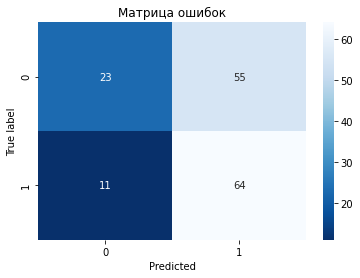

In [1293]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Метрика recall показывает все ли истинные получили 1, в нашем случае она составляет всего 0.87, метрика precision показывает количество случаев, когда вместо 0 предсказали 1, значение метрики - 0.54
Для заказчика главное - вкус молока, значит нам необходимо, чтобы precision равнялась 100 (то есть критичнее ошибка первого рода) (чтобы коровы, дающие невкусное молоко, не были куплены). Изменим порог классификации так, чтобы достичь этого значения

In [1294]:
porog = 0.5
while True:
    porog += 0.01
    y_pred = (clf.predict_proba(X_test)[:,1] >= porog).astype(bool)
    if (precision_score(y_test, y_pred) == 1): break
porog

0.8200000000000003

In [1295]:
y_pred = (clf.predict_proba(X_test)[:,1] >= porog).astype(bool)

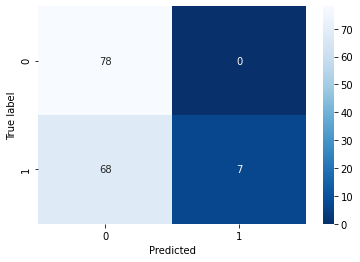

In [1296]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

При пороге в 0.8 количество ошибок 1 рода составляет 0.

In [1297]:
accuracy_score(y_test, y_pred)

0.5555555555555556

In [1298]:
recall_score(y_test, y_pred)

0.09333333333333334

In [1299]:
precision_score(y_test, y_pred)

1.0

**Промежуточный вывод:**

При пороге в 0.8 количество ошибок первого рода равно нулю. При этом количество ошибок второго рода сильно увеличилось, но перого - сведены к нулю по условию задачи

In [1300]:
X

,протеин,порода_коровы,тип_пастбища,порода_быка,жирность,белок,возраст,спо_кат,эке2,имя_быка,вкус_молока_кат
0,1743,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет,0.0,201.64,Буйный,1.0
1,2138,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет,0.0,163.84,Соловчик,1.0
2,1854,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет,0.0,196.00,Барин,0.0
3,2012,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет,0.0,153.76,Буйный,0.0
4,1675,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет,0.0,163.84,Барин,1.0
...,...,...,...,...,...,...,...,...,...,...,...
607,1964,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,более_2_лет,1.0,237.16,Буйный,0.0
608,1700,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,менее_2_лет,0.0,166.41,Барин,1.0
609,1837,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,более_2_лет,0.0,207.36,Барин,0.0
610,1994,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,более_2_лет,0.0,190.44,Барин,1.0


In [1301]:
X_train_full = X

In [1302]:
cow_buy = cow_buy.rename(columns={
    'жирность_текущая': 'жирность',
    'белок_текущий': 'белок',
})


In [1303]:
cow_buy

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность,белок,возраст,эке,протеин,спо,спо_кат,эке2,удой_прогноз
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6317.706397
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6593.829776
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6535.591403
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6354.939992
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6542.483128
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6369.053045


In [1304]:
cat_col_names = ['возраст', 'порода_коровы', 
                 'тип_пастбища', 'порода_быка', 
                 'спо_кат', 'имя_быка']
num_col_names = ['эке2', 'протеин', 'жирность', 'белок']

cow_buy_ml_2 = cow_buy.drop(['удой_прогноз', 'спо', 'эке'] , axis = 1)


In [1305]:
cow_buy_ml_2

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность,белок,возраст,протеин,спо_кат,эке2
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2018.417402,1.0,233.208082
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2018.417402,1.0,233.208082
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2018.417402,1.0,233.208082
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2018.417402,1.0,233.208082
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2018.417402,1.0,233.208082
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,2018.417402,1.0,233.208082
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2018.417402,1.0,233.208082
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2018.417402,1.0,233.208082
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2018.417402,1.0,233.208082
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2018.417402,1.0,233.208082


In [1306]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train_full[cat_col_names])
X_test_ohe = encoder.transform(cow_buy_ml_2[cat_col_names])
encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[num_col_names])
X_test_scaled = scaler.transform(cow_buy_ml_2[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train_full = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1307]:
predictions = (clf.predict_proba(X_test_full)[:,1] >= 0.81).astype(bool)
cow_buy['вкус_молока_прогноз'] = predictions
cow_buy.loc[cow_buy['вкус_молока_прогноз'] == True, 'вкус_молока_прогноз'] = 'вкусное'
cow_buy.loc[cow_buy['вкус_молока_прогноз'] == False, 'вкус_молока_прогноз'] = 'не вкусное'
cow_buy.head()

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность,белок,возраст,эке,протеин,спо,спо_кат,эке2,удой_прогноз,вкус_молока_прогноз
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6581.731529,не вкусное
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6317.706397,не вкусное
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6284.425388,не вкусное
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6593.829776,не вкусное
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.271152,2018.417402,0.95888,1.0,233.208082,6535.591403,не вкусное


В рамках данного этапа была обучена модель логистическое регрессии, посчитаны метрики, подобран порог для сведения к нулю ошибки первого рода, а также спрогнозирован вкус молока.

In [1308]:
cow_buy.loc[(cow_buy['удой_прогноз'] > 6000) & (cow_buy['вкус_молока_прогноз'] == "вкусное")]

,порода_коровы,тип_пастбища,порода_быка,имя_быка,жирность,белок,возраст,эке,протеин,спо,спо_кат,эке2,удой_прогноз,вкус_молока_прогноз


В данном прогнозе нет буренки, удовлетворяющие интересам фермера

## Итоговые выводы

В рамках данной работы были изучены несколько датафреймов. Они были проверены на пропуски и дубликаты. Пропусков не было, дубликаты были удалены. Также заданы нужные форматы жанных (object -> int/float).

В предобработке данных я привела название столбцов к "змеиному_регистру", а также исправила два неявных дубликата в датафрейме ferma_main.

С помощью исследовательского анализа был замечен и удален выброс у признаке "удой". Выбросы в признаке "жирность варьируются с 2.99 до 3.75 и составляют более 13% от всего датасета - было принято решение оставить их. А в признаке "белок" выбросы были удалены, так как их количество составило 3%. На гистограммах распределения видно, что "ЭКЕ", "белок", "удой" имеют нормальное распределение, "протеин" и "жиры" не имеют нормальное распределение, но выглядят достоверно, а признак "спо" будто сгруппирован. Все категориальные признаки рапределены практически в равных долях, кроме вкуса молока (вкусного больше) и возраста (основная доля коров старше 2 лет).

Корреляционный анализ показал следующие зваимосвязи: удой напрямую зависит от возраста, также видна зависимость меду возрастом и эке, возрастом и спо, но не такая "сильная". Совершенно нет корреляционной связи между следующими парами: белок-эке, белок-спо, белок-жирность, возраст-белок, вкус молока-порода, жирность-порода, жирность-тип пастбища, протеин-порода.

Обучение модели линейной регрессии происходило в три этапа: сначала был выбран целевой признак "удой", а для входных исключены "id", "белок", "жирность", "вкус молока", так как они относятся характеристикам уже полученного продукта и не влияют на удой. После анализа графиков остатков, дисперсии и метрик признак "спо" был приведен к категориальному формату - так была обучена вторая модель. Замем был добавлен еще один категориальный признак "имя_быка". Данные действия привели к улучшению модели: значение коэффициента детерминации вырос с 0.795 до 0.846, распределение остатков улучшилось, но смещение осталось, дисперсия стала значительно плотнее и равномерней. Также с точки зрения оценки по метрикам MSE, MAE и RMSE третья модель имеет наилучшие показатели. Чем меньше ошибки, тем лучше модель предсказывает целевой признак.

С помощью третьей модели был предсказан удой буренок. Мы получили 15 коров, приносящих более 6000 кг молока в год.

Затем проведено обучение модели логистической регрессии для предсказания вкуса молока. Для этого была обучена модель, также с помощью матрицы ошибок были исключены ошибки первого рода и получен прогноз.

В результате мы не получили коров, удоблетворяющих двум условиям.